# Sylhet Floods 2022
## shapeToRasterUNOSAT.ipynb
This script converts the UNOSAT water extent shapefiles into rasters. UNOSAT maps were downloaded in shapefile format from the Humanitarian Data Exchange.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
import rasterio
import rasterio.features as features
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Set the root path for accessing the data on Mule
rootPath = Path('Z:\\media/mule/Projects/NASA/NIP/Data/')

## PART 1: Load the UNOSAT shapefiles

In [3]:
shapePath = rootPath/'Shapefiles/SylhetUNOSAT'
os.listdir(shapePath)

['RCM1_20220619_WaterExtent_NE.cpg',
 'RCM1_20220619_WaterExtent_NE.dbf',
 'RCM1_20220619_WaterExtent_NE.prj',
 'RCM1_20220619_WaterExtent_NE.sbn',
 'RCM1_20220619_WaterExtent_NE.sbx',
 'RCM1_20220619_WaterExtent_NE.shp',
 'RCM1_20220619_WaterExtent_NE.shp.xml',
 'RCM1_20220619_WaterExtent_NE.shx',
 'S1_20220525_20220528_WaterExtent_NE.cpg',
 'S1_20220525_20220528_WaterExtent_NE.dbf',
 'S1_20220525_20220528_WaterExtent_NE.prj',
 'S1_20220525_20220528_WaterExtent_NE.sbn',
 'S1_20220525_20220528_WaterExtent_NE.sbx',
 'S1_20220525_20220528_WaterExtent_NE.shp',
 'S1_20220525_20220528_WaterExtent_NE.shp.xml',
 'S1_20220525_20220528_WaterExtent_NE.shx',
 'S1_20220525_WaterExtent_NE.cpg',
 'S1_20220525_WaterExtent_NE.dbf',
 'S1_20220525_WaterExtent_NE.prj',
 'S1_20220525_WaterExtent_NE.sbn',
 'S1_20220525_WaterExtent_NE.sbx',
 'S1_20220525_WaterExtent_NE.shp',
 'S1_20220525_WaterExtent_NE.shp.xml',
 'S1_20220525_WaterExtent_NE.shx']

In [4]:
# Read in the water extent shapefile water 
shape = gpd.read_file(shapePath/'S1_20220525_WaterExtent_NE.shp')

In [5]:
# Open the modified Devries temp raster, to use as raster reference for extent, shape, crs
rasterPath = rootPath/'Raster/Sylhet/Sen1MitchellSingleOrbit/Mosaic'
raster = rasterio.open(rasterPath/'temp.tif')

In [6]:
# NOTE: shape crs is EPSG:9707 - WGS 84, need to standardize with the raster crs
print(shape.crs)
print(raster.crs)

epsg:9707
EPSG:32646


In [7]:
# Reproject the shapefile into the raster CRS
shape_reproj = shape.copy()
shape_reproj = shape_reproj.to_crs(epsg=32646)

In [8]:
# Get list of geometries for all features in shape file
geom = [shapes for shapes in shape_reproj.geometry]

In [9]:
# Rasterize the extent shape using the shape and coordinate system of the raster
rasterized_false = features.rasterize(geom,
                                    out_shape = raster.shape,
                                    fill = 0, # no water values
                                    out = None,
                                    transform = raster.transform,
                                    all_touched = False, # determines which raster pixels get value or not, depending if they are fully inside polygon (False) or just touch it (True)
                                    default_value = 1, # water values
                                    dtype = None)

In [10]:
# Create second version with all_touched = True to check the difference
rasterized_true = features.rasterize(geom,
                                    out_shape = raster.shape,
                                    fill = 0, # no water values
                                    out = None,
                                    transform = raster.transform,
                                    all_touched = True, # determines which raster pixels get value or not, depending if they are fully inside polygon (False) or just touch it (True)
                                    default_value = 1, # water values
                                    dtype = None)

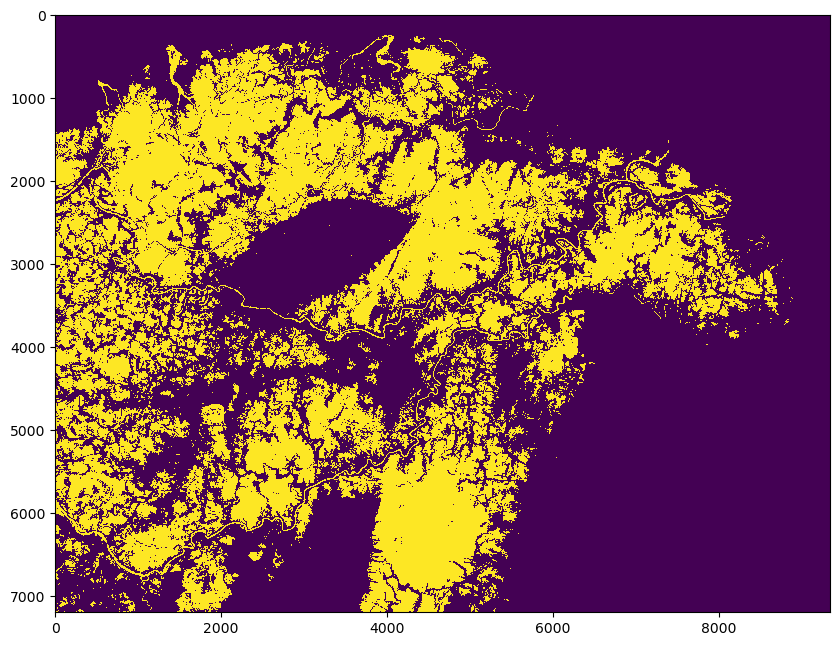

In [11]:
# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
plt.imshow(rasterized_false, interpolation='none')
plt.show()

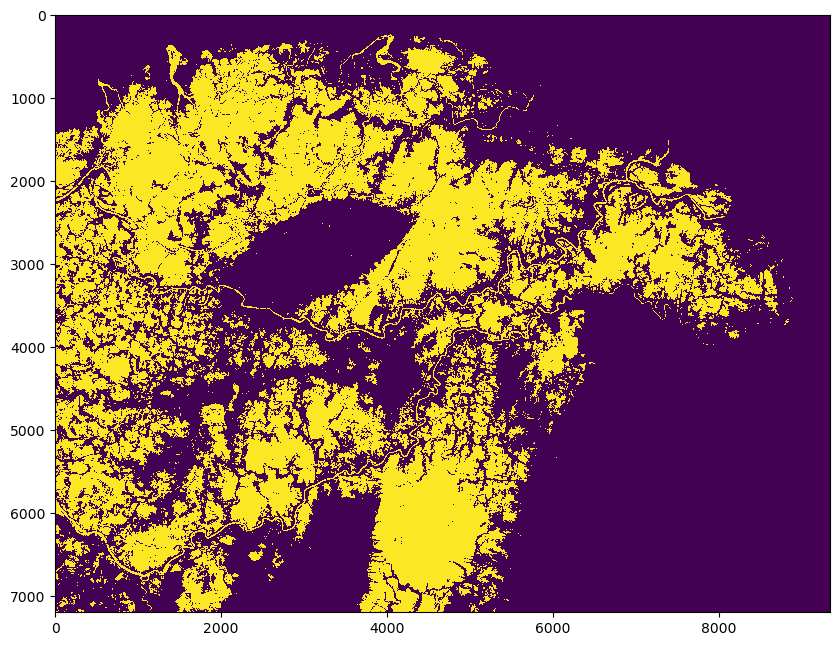

In [12]:
# Plot raster with all_touched = True, should be more conservative in extent
fig, ax = plt.subplots(1, figsize = (10, 10))
plt.imshow(rasterized_true, interpolation='none')
plt.show()

In [14]:
# Export both versions
outputPath = rootPath/'Raster/SylhetUNOSAT'
outputPath.mkdir(exist_ok=True)

# Output the mosaic
outputName = 'S1_20220525_WaterExtent_NE_allTouchTrue.tif'
with rasterio.open(
        outputPath/outputName, 'w',
        driver = 'GTiff',
        transform = raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = raster.width,
        height = raster.height,
        crs=raster.crs) as dst:
    dst.write(rasterized_true, indexes = 1)